# ResNet 识别手写字体
在神经网络深度增加的时候，梯度消失的问题就变得棘手了，所以 ResNet 在之前的网络中增加了改进，将残差块的输入引入到输出之中一同进行求导。


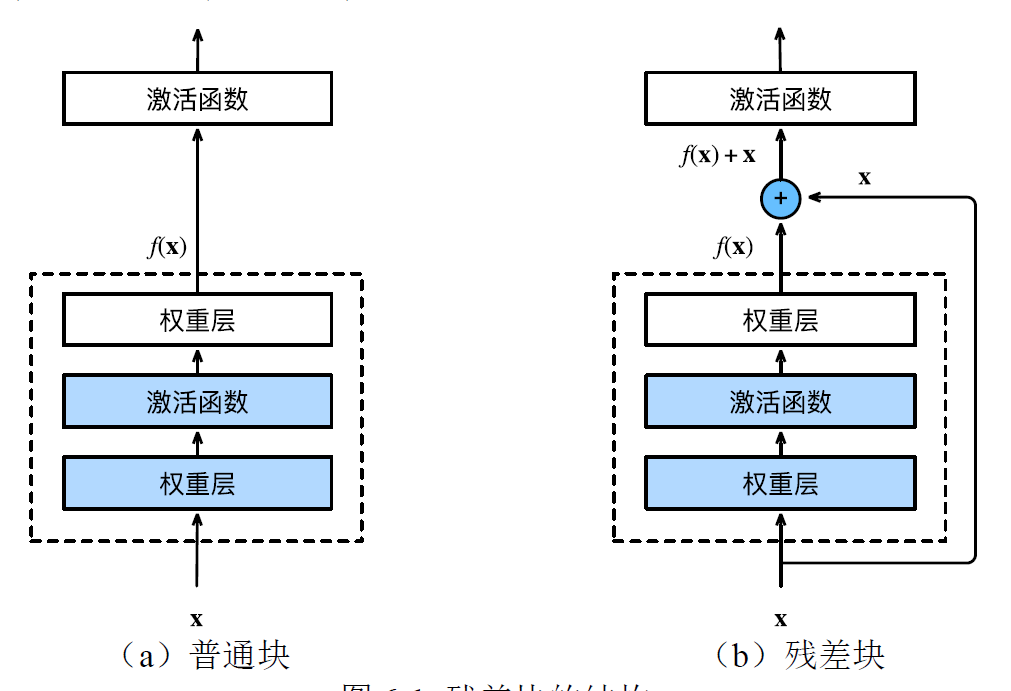

In [1]:
from IPython.display import Image

Image(filename='./images/ResNet 残差块.png')

In [2]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_inline import backend_inline

# 数据集相关
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

In [3]:
transform = transforms.Compose(  # 将多个图像变换操作组合在一起
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

# 下载训练集
train_data = datasets.MNIST(
    root='./datasets/mnist/',
    train=True,
    download=True,
    transform=transform
)
test_data = datasets.MNIST(
    root='./datasets/mnist/',
    train=False,
    download=True,
    transform=transform
)

# 批次加载器
train_loader = DataLoader(train_data, shuffle=True, batch_size=256)
test_loader = DataLoader(test_data, shuffle=False, batch_size=256)

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return nn.functional.relu(self.net(x) + x)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(16),
            nn.Conv2d(16, 32, kernel_size=5), nn.ReLU(),
            nn.MaxPool2d(2),
            ResidualBlock(32),
            nn.Flatten(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.net(x)

In [5]:
X = torch.rand(size=(1, 1, 28, 28))
for layer in CNN().net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2d output shape: 	 torch.Size([1, 16, 24, 24])
ReLU output shape: 	 torch.Size([1, 16, 24, 24])
MaxPool2d output shape: 	 torch.Size([1, 16, 12, 12])
ResidualBlock output shape: 	 torch.Size([1, 16, 12, 12])
Conv2d output shape: 	 torch.Size([1, 32, 8, 8])
ReLU output shape: 	 torch.Size([1, 32, 8, 8])
MaxPool2d output shape: 	 torch.Size([1, 32, 4, 4])
ResidualBlock output shape: 	 torch.Size([1, 32, 4, 4])
Flatten output shape: 	 torch.Size([1, 512])
Linear output shape: 	 torch.Size([1, 10])


In [6]:
net = CNN().to('cuda')

learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

85.19628253765404
15.32367545645684
12.773369723930955
11.748417457565665
11.185803515836596
11.515574210323393
11.215320116840303
11.320933521725237
10.99225561786443
10.615293703973293


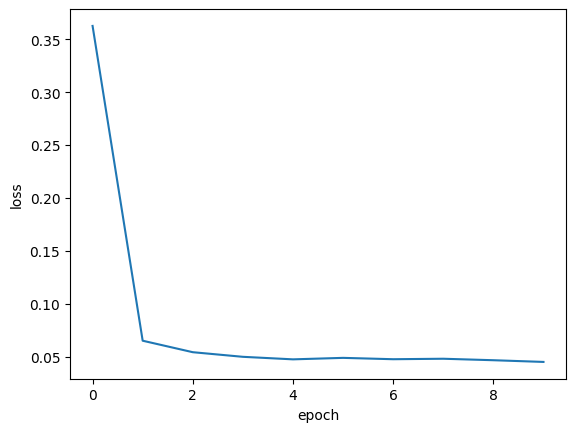

In [7]:
epochs = 10
losses = []

for epoch in range(epochs):
    avg_loss = 0
    times = 0

    for x, y in train_loader:
        x = x.to('cuda')
        y = y.to('cuda')
        pred = net(x)
        loss = loss_fn(pred, y)
        avg_loss += loss.item()
        times += 1
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(avg_loss)
    losses.append(avg_loss / times)

Fig = plt.figure()
plt.plot(range(epochs), losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [8]:
# 测试网络
correct = 0
total = 0

with torch.no_grad():
    for (x, y) in test_loader:
        # 获取小批次的x与y
        x, y = x.to('cuda:0'), y.to('cuda:0')
        Pred = net(x)
        # 该局部关闭梯度计算功能
        # 一次前向传播（小批量）
        _, predicted = torch.max(Pred.data, dim=1)
        correct += torch.sum((predicted == y))
        total += y.size(0)

print(f'测试集精准度: {100 * correct/total} %')

测试集精准度: 98.29000091552734 %


In [9]:
from tools.ipynb_draw import DrawCanvas
from IPython.display import display
from ipywidgets import Button
from PIL import Image

dc = DrawCanvas(width=48, height=48, brush_size=6)

callback_button = Button(description="识别")

def callback(_):
    with dc.out:
        try:
            np_img = dc.canvas.get_image_data(width=48, height=48)
            img = Image.fromarray(np_img)
            transform = transforms.Compose([
                transforms.Grayscale(),  # 如果是彩色图像转为灰度
                transforms.Resize((28, 28)),  # 调整大小为 28 * 28
                transforms.ToTensor(),  # 转为张量并归一化到[0,1]
                transforms.Normalize((0.1307,), (0.3081,))  # 标准化到[-1,1]
            ])

            # 对图像进行预处理
            input_tensor = transform(img).unsqueeze(0).to('cuda')  # 添加batch维度 (1, 1, 28, 28)

            # 3. 前向传播
            with torch.no_grad():  # 不需要计算梯度
                output = net(input_tensor)
                prediction = torch.argmax(output, dim=1).item()  # 获取预测类别
                print(prediction)
        except BaseException as e:
            print(str(e))

callback_button.on_click(callback)


layout = dc.get_layout()
layout.children[1].children = layout.children[1].children + (callback_button,)
display(layout)